In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
dir_path_train='/content/drive/My Drive/Colab Notebooks/US_Data/train' 
dir_path_test='/content/drive/My Drive/Colab Notebooks/US_Data/test' 

In [5]:
imagePathsTrain = list(paths.list_images(dir_path_train))
imagePathsTest = list(paths.list_images(dir_path_test))
train_labels, test_labels = [], []
train_data, test_data = [], []
IMG_WIDTH, IMG_HEIGHT=224,224

In [6]:
for imagePath in imagePathsTrain:

    path_parts = imagePath.split(os.path.sep)
    # extract the split
    train_test = path_parts[-3][-1]
    # extract the class label from the filename
    label = path_parts[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    train_labels.append(label)
    train_data.append(image)   

In [7]:
for imagePath in imagePathsTest:

    path_parts = imagePath.split(os.path.sep)
    # extract the split
    train_test = path_parts[-3][-1]
    # extract the class label from the filename
    label = path_parts[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    test_labels.append(label)
    test_data.append(image)

Class1


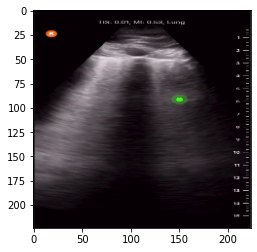

In [8]:
idx=25
plt.imshow(train_data[idx])
print(train_labels[idx])

In [9]:
train_data = np.array(train_data) / 255.0
test_data = np.array(test_data) / 255.0
train_labels_text = np.array(train_labels)
test_labels_text = np.array(test_labels)
num_classes = len(set(train_labels))

In [10]:
lb = LabelBinarizer()
lb.fit(train_labels_text)
train_labels = lb.transform(train_labels_text)
test_labels = lb.transform(test_labels_text)
print('Class mappings are:', lb.classes_)

Class mappings are: ['Class0' 'Class1']


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    AveragePooling2D, Dense, Dropout, Flatten, Input, BatchNormalization, ReLU
)
from tensorflow.keras.models import Model
hidden_size=64
dropout = 0.5

# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMG_WIDTH, IMG_HEIGHT,3))
)
# construct the head of the model that will be placed on top of the
# the base model
hidden = baseModel.output
hidden = Flatten(name="flatten")(hidden)
hidden = Dense(hidden_size)(hidden)
hidden = BatchNormalization()(hidden)
hidden = ReLU()(hidden)
hidden = Dropout(dropout)(hidden)    
output = Dense(num_classes, activation="softmax")(hidden)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=output)

58892288/58889256 [==============================] - 2s 0us/step


In [12]:
num_layers = len(model.layers)
for ind, layer in enumerate(model.layers):
    if ind < num_layers - 5:
        layer.trainable = False

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
opt = Adam(learning_rate=0.01)
EPOCHS=20
BATCH_SIZE=64
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
H=model.fit(x=train_data,y=train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(test_data,test_labels))

Epoch 1/5
3/3 [==============================] - 2s 612ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.6805 - val_accuracy: 0.7391
Epoch 2/5
3/3 [==============================] - 2s 532ms/step - loss: 6.7822e-05 - accuracy: 1.0000 - val_loss: 2.7333 - val_accuracy: 0.7391
Epoch 3/5
3/3 [==============================] - 2s 535ms/step - loss: 5.9056e-04 - accuracy: 1.0000 - val_loss: 2.5876 - val_accuracy: 0.7391
Epoch 4/5
3/3 [==============================] - 2s 536ms/step - loss: 8.3947e-05 - accuracy: 1.0000 - val_loss: 2.4681 - val_accuracy: 0.7391
Epoch 5/5
3/3 [==============================] - 2s 530ms/step - loss: 1.2179e-04 - accuracy: 1.0000 - val_loss: 2.3334 - val_accuracy: 0.7391


In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
H=model.fit(trainAug.flow(train_data, train_labels, batch_size=BATCH_SIZE),batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(test_data,test_labels))

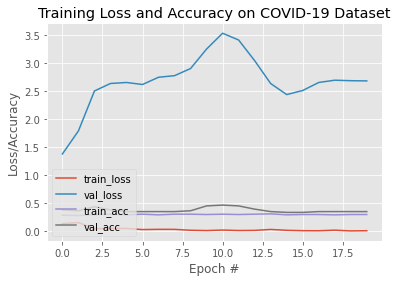

In [17]:
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')

In [18]:
print('Evaluating network...')
predIdxs = model.predict(test_data, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        test_labels, predIdxs, target_names=lb.classes_
    )
)

Evaluating network...
classification report sklearn:
              precision    recall  f1-score   support

      Class0       0.42      0.71      0.53        14
      Class1       0.91      0.75      0.82        55

    accuracy                           0.74        69
   macro avg       0.66      0.73      0.67        69
weighted avg       0.81      0.74      0.76        69



In [20]:
print('confusion matrix:')
cm = confusion_matrix(test_labels, predIdxs)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

confusion matrix:
[[10  4]
 [14 41]]


In [27]:
len(train_data)

166